# Handwritten Digit Recognition with Neural Network (from Scratch)
This notebook builds a simple neural network using only NumPy, Pandas to classify digits from the MNIST dataset.
We’ll walk through data loading, preprocessing, model creation, training, and evaluation.

## 1. Importing Required Libraries
We start by importing NumPy for numerical operations, pandas for data handling, and matplotlib for visualization.


In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Loading the Dataset
We load the `train.csv` file which contains labeled images of handwritten digits. Each row represents one image.

In [22]:
# Load the MNIST training dataset
data = pd.read_csv("train.csv")

# Display the shape of the dataset
print(f"Loaded dataset with shape: {data.shape}")

Loaded dataset with shape: (42000, 785)


## 3. Exploring the Dataset
We convert the dataset to a NumPy array and print its dimensions to understand how many examples and features we have.

In [23]:
# Convert DataFrame to NumPy array and get dataset shape
data = np.array(data)
m, n = data.shape
print(f"Dataset contains {m} examples with {n} features (including the label).")

Dataset contains 42000 examples with 785 features (including the label).


## 4. Data Preprocessing

Before training the neural network, we need to prepare the dataset:

1. **Shuffle** the data to remove any ordering bias
2. **Normalize** the pixel values from the range [0, 255] to [0, 1]
3. **Split** the data into a training set and a dev set
4. **Transpose** the input matrix so that each column represents one training example

---

#### Why Transpose?

Neural networks process data as:

$$
X = [x^{(1)}, x^{(2)}, ..., x^{(m)}] \in \mathbb{R}^{n \times m}
$$

Where:
- \( n \) is the number of features (in our case, 784 pixels per image)
- \( m \) is the number of training examples

This column-wise format allows vectorized matrix operations like:

$$
Z = W X + b
$$

to apply the same weights across all examples efficiently.  
So, we reshape our dataset to match this expected structure before feeding it into the network.


In [24]:
# Shuffle the dataset to avoid any ordering bias
np.random.shuffle(data)

# Split the dataset into training and dev sets
# Transpose so that each column represents one example
data_dev = data[1:1000].T
X_dev = data_dev[1:] / 255.0  # Normalize pixel values
Y_dev = data_dev[0]

data_train = data[1000:].T
X_train = data_train[1:] / 255.0  # Normalize pixel values
Y_train = data_train[0]

# Get the number of training examples
_, m_train = X_train.shape

## 5. Neural Network Implementation

### 5.1 Neural Network Architecture Overview
We build a simple feedforward neural network with the following structure:
- **Input layer**: 784 units (one for each pixel in a 28×28 grayscale image)
- **Hidden layer**: 10 neurons with ReLU activation
- **Output layer**: 10 neurons with softmax activation, one for each digit class (0–9)
---

### 5.2 Initializing Parameters
- We randomly initialize the weights and biases for both layers.
- This helps break symmetry and allows the network to begin learning.
---

### 5.3 Activation Functions
We define the activation functions used in the network:
- **ReLU (Rectified Linear Unit)** for the hidden layer
- **Softmax** for the output layer to convert scores into probabilities
---

### 5.4 Forward Propagation

In forward propagation, we compute activations layer by layer using weights, biases, and activation functions.

Let:

- $X \in \mathbb{R}^{784 \times m}$: input matrix (each column is an image)
- $W^{[1]} \in \mathbb{R}^{10 \times 784}$, $b^{[1]} \in \mathbb{R}^{10 \times 1}$: weights and bias of the first (hidden) layer
- $W^{[2]} \in \mathbb{R}^{10 \times 10}$, $b^{[2]} \in \mathbb{R}^{10 \times 1}$: weights and bias of the output layer
- $m$: number of training examples

#### Step-by-step Computation:

**Hidden layer**:

$$
Z^{[1]} = W^{[1]} X + b^{[1]}
$$

$$
A^{[1]} = \text{ReLU}(Z^{[1]}) = \max(0, Z^{[1]})
$$

**Output layer**:

$$
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}
$$

$$
A^{[2]} = \text{softmax}(Z^{[2]}) = \frac{e^{Z^{[2]}}}{\sum e^{Z^{[2]}}}
$$

Softmax is applied column-wise to ensure each column of \( A^{[2]} \) sums to 1.

#### Example Output:

If the image is a "3", then:

$$
A^{[2]} = [0.01, 0.02, 0.01, \mathbf{0.94}, 0.01, \dots]
$$

---

### 5.5 One-Hot Encoding

In a multi-class classification problem like digit recognition (0–9), we need to compare the predicted probabilities with the true labels.  
Since labels are scalar integers (e.g., 3, 7), we convert them into **one-hot encoded vectors** for mathematical compatibility during loss calculation and backpropagation.

#### Definition:

If a label $y = 3$, the corresponding one-hot encoded vector $\mathbf{y} \in \mathbb{R}^{10 \times 1}$ is:

$$
\mathbf{y} = 
\begin{bmatrix}
0 \\
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{bmatrix}
$$

So in general:

- If $Y \in \mathbb{R}^{1 \times m}$ contains labels (digits 0–9),
- Then one-hot encoding creates $Y_{\text{one-hot}} \in \mathbb{R}^{10 \times m}$, where each column is a one-hot vector.

#### Why it's important:

During backpropagation, we subtract the one-hot encoded labels from the predicted softmax probabilities:

$$
\delta^{[2]} = A^{[2]} - Y_{\text{one-hot}}
$$

This allows us to compute the **cross-entropy gradient** effectively.

---

### 5.6 Backward Propagation

Once we compute predictions using forward propagation, we calculate how far off the predictions are from the actual labels. Backward propagation helps us compute the **gradients** of the loss with respect to each parameter so we can update them and reduce the error.

#### Loss Function

We use **cross-entropy loss** for multi-class classification:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{10} Y_j^{(i)} \log\left(A_j^{[2](i)}\right)
$$

Where:
- $Y^{(i)}$ is the one-hot encoded true label for the $i$-th training example
- $A^{[2](i)}$ is the predicted softmax output for the $i$-th example
- $m$ is the total number of examples

#### Gradients for Output Layer

Let:
- $A^{[2]} \in \mathbb{R}^{10 \times m}$: output of the softmax layer
- $Y \in \mathbb{R}^{10 \times m}$: one-hot encoded labels

Then the error at the output is:

$$
\delta^{[2]} = A^{[2]} - Y
$$

Gradients for weights and biases in the output layer:

$$
\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \frac{1}{m} \delta^{[2]} (A^{[1]})^T
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \frac{1}{m} \sum_{i=1}^{m} \delta^{[2](i)}
$$

#### Gradients for Hidden Layer

We propagate the error back to the hidden layer:

$$
\delta^{[1]} = (W^{[2]})^T \delta^{[2]} \circ \mathbb{1}(Z^{[1]} > 0)
$$

Where:
- $\circ$ denotes element-wise multiplication (Hadamard product)
- $\mathbb{1}(Z^{[1]} > 0)$ is the derivative of ReLU (i.e., 1 where $Z^{[1]} > 0$, else 0)

Gradients for weights and biases in the hidden layer:

$$
\frac{\partial \mathcal{L}}{\partial W^{[1]}} = \frac{1}{m} \delta^{[1]} X^T
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{[1]}} = \frac{1}{m} \sum_{i=1}^{m} \delta^{[1](i)}
$$

Backward propagation allows the network to understand how each parameter contributed to the error and adjust accordingly using gradient descent. This is the core of how the network "learns".

---

### 5.7 Updating Parameters

We update the weights and biases using gradient descent to minimize the loss.

Let:
- $\alpha$ be the learning rate
- $\frac{\partial \mathcal{L}}{\partial W^{[l]}}$, $\frac{\partial \mathcal{L}}{\partial b^{[l]}}$ be the gradients for layer $l$

Update rules:

$$
W^{[l]} := W^{[l]} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial W^{[l]}}, \quad
b^{[l]} := b^{[l]} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial b^{[l]}}
$$

Applied to both layers ($l = 1, 2$). The learning rate $\alpha$ controls the step size.

---

### 5.8 Making Predictions and Evaluating Accuracy

To get the predicted label, we take the index of the highest value from the softmax output $A^{[2]}$:

$$
\text{predictions} = \arg\max(A^{[2]}, \text{ axis}=0)
$$

Accuracy is computed by comparing these predictions to the true labels $Y$:

$$
\text{Accuracy} = \frac{1}{m} \sum_{i=1}^{m} \mathbb{1}(\text{prediction}^{(i)} = Y^{(i)})
$$

Where:
- $A^{[2]}$ is the output from the softmax layer
- $\text{prediction}^{(i)}$ is the predicted class for the $i$-th example
- $Y^{(i)}$ is the true label
- $\mathbb{1}(\cdot)$ is an indicator function that returns 1 if the condition is true, and 0 otherwise
---


In [25]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_size=10, output_size=10):
        self.W1 = np.random.rand(hidden_size, input_size) - 0.5
        self.b1 = np.random.rand(hidden_size, 1) - 0.5
        self.W2 = np.random.rand(output_size, hidden_size) - 0.5
        self.b2 = np.random.rand(output_size, 1) - 0.5

    def ReLU(self, Z):
        return np.maximum(0, Z)

    def ReLU_deriv(self, Z):
        return Z > 0

    def softmax(self, Z):
        Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
        expZ = np.exp(Z_shifted)
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def forward(self, X):
        Z1 = self.W1 @ X + self.b1
        A1 = self.ReLU(Z1)
        Z2 = self.W2 @ A1 + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.max()+1, Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y

    def backward(self, X, Y, Z1, A1, A2):
        m = X.shape[1]
        one_hot_Y = self.one_hot(Y)
        dZ2 = A2 - one_hot_Y
        dW2 = 1/m * dZ2 @ A1.T
        db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = (self.W2.T @ dZ2) * self.ReLU_deriv(Z1)
        dW1 = 1/m * dZ1 @ X.T
        db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
        return dW1, db1, dW2, db2

    def update(self, dW1, db1, dW2, db2, alpha):
        self.W1 -= alpha * dW1
        self.b1 -= alpha * db1
        self.W2 -= alpha * dW2
        self.b2 -= alpha * db2

    def train(self, X, Y, iterations, alpha):
        for i in range(iterations):
            Z1, A1, Z2, A2 = self.forward(X)
            dW1, db1, dW2, db2 = self.backward(X, Y, Z1, A1, A2)
            self.update(dW1, db1, dW2, db2, alpha)
            if i % 10 == 0:
                preds = self.predict(X)
                acc = self.accuracy(preds, Y)
                print(f"Iteration {i} - Accuracy: {acc:.4f}")

    def predict(self, X):
        _, _, _, A2 = self.forward(X)
        return np.argmax(A2, axis=0)

    def accuracy(self, preds, Y):
        return np.mean(preds == Y)


## 6. Training the Model

We now train the neural network using the training set.

In each iteration, the model:
- Performs forward propagation to compute predictions
- Uses backward propagation to calculate gradients
- Updates weights and biases using gradient descent

We repeat this process for a fixed number of iterations (e.g., 500).  
This allows the model to gradually minimize the loss and improve accuracy.

The **learning rate**, denoted by alpha $\alpha$, controls how big each parameter update step is:
- A small $\alpha$ (e.g., 0.01) leads to slower but stable learning
- A large $\alpha$ (e.g., 0.5) may speed up training but can overshoot or diverge

In our case, we use:
- Iterations = 500
- alpha = 0.10 (Change the weights and biases by 10% of the calculated gradient every iteration.)

In [26]:
# Create the neural network instance and begin training
nn = NeuralNetwork()
nn.train(X_train, Y_train, iterations=500, alpha=0.1)

Iteration 0 - Accuracy: 0.0541
Iteration 10 - Accuracy: 0.1139
Iteration 20 - Accuracy: 0.1526
Iteration 30 - Accuracy: 0.1922
Iteration 40 - Accuracy: 0.2522
Iteration 50 - Accuracy: 0.2791
Iteration 60 - Accuracy: 0.3049
Iteration 70 - Accuracy: 0.3337
Iteration 80 - Accuracy: 0.3677
Iteration 90 - Accuracy: 0.4087
Iteration 100 - Accuracy: 0.4556
Iteration 110 - Accuracy: 0.5070
Iteration 120 - Accuracy: 0.5447
Iteration 130 - Accuracy: 0.5719
Iteration 140 - Accuracy: 0.5915
Iteration 150 - Accuracy: 0.6097
Iteration 160 - Accuracy: 0.6261
Iteration 170 - Accuracy: 0.6409
Iteration 180 - Accuracy: 0.6551
Iteration 190 - Accuracy: 0.6689
Iteration 200 - Accuracy: 0.6815
Iteration 210 - Accuracy: 0.6927
Iteration 220 - Accuracy: 0.7040
Iteration 230 - Accuracy: 0.7156
Iteration 240 - Accuracy: 0.7250
Iteration 250 - Accuracy: 0.7348
Iteration 260 - Accuracy: 0.7437
Iteration 270 - Accuracy: 0.7524
Iteration 280 - Accuracy: 0.7606
Iteration 290 - Accuracy: 0.7680
Iteration 300 - Accur

### 7. Making Predictions and Visualizing Results

After training the model, we can test its performance on individual examples.

- The `predict()` method in our class uses forward propagation to compute the output and selects the digit with the highest probability.
- We define a helper function `test_prediction()` to:
  - Run prediction on a single example (by index)
  - Display the predicted digit and actual label
  - Show the corresponding image (28×28 grayscale)

This helps us visually inspect whether the model is correctly identifying handwritten digits.

In [34]:
# Function to make predictions using the trained model (for any dataset)
def make_predictions(model, X):
    return model.predict(X)

# Function to test a single example and show the image with prediction
def test_prediction(index, model, X_data, Y_data):
    """
    Displays the image at the given index and compares the model's prediction to the actual label.
    """
    current_image = X_data[:, index, None]  # shape (784, 1)
    prediction = make_predictions(model, current_image)
    label = Y_data[index]

    # print(f"Prediction: {prediction[0]}")
    # print(f"Actual Label: {label}")

    # Visualize the image
    image_2d = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image_2d, interpolation='nearest')
    plt.title(f"Predicted: {prediction[0]}, Actual: {label}")
    plt.axis('off')
    plt.show()


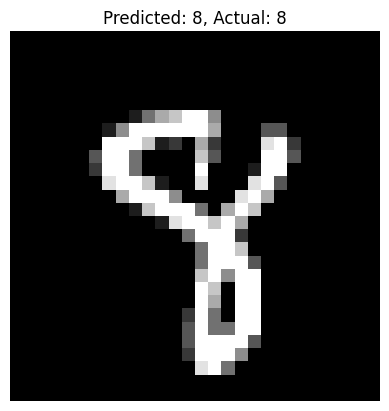

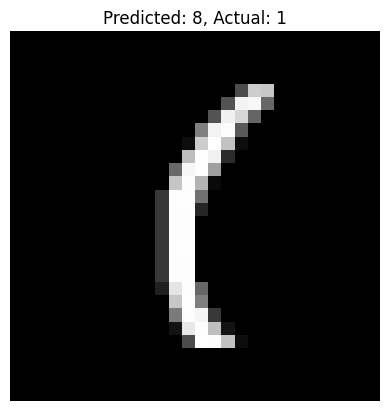

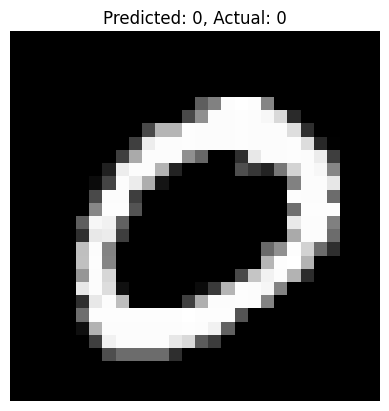

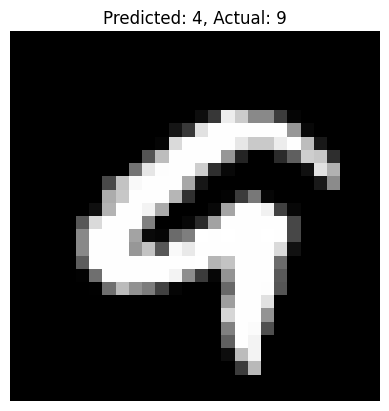

In [35]:
# Test on a few training examples
for i in range(4):
    test_prediction(i, nn, X_train, Y_train)

### 8. Evaluating on the Dev Set

After training and testing on individual examples, we evaluate the model's performance on the dev set.

- The dev set contains unseen data to test generalization.
- We use the same forward propagation and prediction logic to get outputs.
- Accuracy is calculated by comparing predicted labels with actual labels.

This gives us an unbiased estimate of how well the model will perform on new, unseen data.

In [37]:
dev_predictions = make_predictions(nn,X_dev)
print("Dev Set Accuracy:", nn.accuracy(dev_predictions, Y_dev))

Dev Set Accuracy: 0.8548548548548549
